In [1]:
import os
# 이미지 다운
if not os.path.exists('train2017'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/zips/train2017.zip
    !unzip train2017.zip
    
# 캡션 다운
if not os.path.exists('annotations'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip annotations_trainval2017.zip

In [2]:
# 데이터 분할
# dataPrepare.py에서 데이터 비율 및 vocab을 정의할 수 있다.
if not os.path.exists('dataset'):
    !python3 dataPrepare.py

[nltk_data] Downloading package punkt to /home/whitdisa04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LAN

In [3]:
import os
import pickle
import torch
from torchvision import transforms
from dataLoader import get_loader
from resnet_lstm import *

In [4]:
img_dir = ["./dataset/train/images", "./dataset/val/images", "./dataset/test/images"] 

train_img_path = img_dir[0] # resized image for training
val_img_path = img_dir[1] # resized image for validation
test_img_path = img_dir[2] # resized image for test

coco_caption_path = "./annotations/captions_train2017.json"
train_caption_path = "./dataset/train/captions.txt" # resized image for training
val_caption_path = "./dataset/val/captions.txt" # resized image for validation
test_caption_path = "./dataset/test/captions.txt" # resized image for test

batch_size = 256
learning_rate = 0.001
num_workers = 6
num_epochs = 10

# Increase Model Capacity
embed_size = 256
hidden_size = 1024
num_layers = 1  # More layers can capture complex patterns

vocab_path = "./dataset/vocab.pkl"  # Path to the preprocessed vocabulary file
# Load vocabulary file
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [5]:
model_path = "models/"  # Path where the trained model will be saved
# Create model directory
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Use the same preprocessing and normalization parameters as were applied in the pre-trained Inception model.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor()
])

# Declare data loaders
train_data_loader = get_loader(train_img_path, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False, pin_memory=True)
val_data_loader = get_loader(val_img_path, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False, pin_memory=True)
test_data_loader = get_loader(test_img_path, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True, pin_memory=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Criterion with ignore_index to skip pad tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch_norm.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

/home/whitdisa04/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/whitdisa04/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 평가 함수 정의
def evaluate(encoder, decoder, data_loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return round(total_loss / len(data_loader), 4)

    # 추가: BLEU 점수 계산을 위한 함수
"""
각 n-gram 수준(1-gram, 2-gram, 3-gram, 4-gram)에서 생성된 캡션과 참조 캡션 간의 일치도를 계산합니다.
이러한 각각의 n-gram 일치도에 대해 동일한 가중치(기본적으로 각각 0.25)를 부여하여, 이들의 평균을 계산합니다.
이 평균 점수가 최종 BLEU 점수가 됩니다.
"""
import torchtext.data.metrics as metrics

def calculate_bleu(data_loader, encoder, decoder, vocab, device):
    predictions = []
    references = []
    with torch.no_grad():
        for images, captions, _ in data_loader:
            images = images.to(device)
            features = encoder(images)
            sampled_ids = decoder.sample(features)
            sampled_ids = sampled_ids.cpu().numpy()

            # Convert word_ids to words
            for i in range(len(images)):
                sampled_caption = []
                for word_id in sampled_ids[i]:
                    word = vocab.idx2word[word_id]
                    sampled_caption.append(word)
                    if word == '<end>':
                        break
                predictions.append(sampled_caption[1:-1])

                # Original sentence
                orig_caption = []
                for word_id in captions[i].numpy():
                    word = vocab.idx2word[word_id]
                    orig_caption.append(word)
                    if word == '<end>':
                        break
                references.append([orig_caption[1:-1]])

    bleu1_score = metrics.bleu_score(predictions, references, max_n=4, weights=[1, 0, 0, 0])
    bleu2_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 1, 0, 0])
    bleu3_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 1, 0])
    bleu4_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 0, 1])

    # 변경: BLEU 점수 계산 결과를 다른 변수에 할당
    return bleu1_score, bleu2_score, bleu3_score, bleu4_score


In [8]:
from tqdm import tqdm

# Gradient clipping value
clip_value = 5

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 훈련 손실 누적
train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()

    train_loss = 0  # 에포크 시작 전 훈련 손실 초기화
    # 여기에 tqdm을 추가합니다. 이는 train_data_loader의 각 배치에 대한 진행 상태를 표시합니다.
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as t:
        for i, (images, captions, lengths) in t:
            # Move batch of images and captions to GPU if available
            images, captions = images.to(device), captions.to(device)

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Calculate the batch loss based on the criterion
            loss = criterion(outputs, targets)
            train_loss += loss.item()  # 각 배치의 손실 누적
            decoder.zero_grad()
            encoder.zero_grad()

            # Backward pass (compute gradients)
            loss.backward()

            # Clip gradients
            clip_params = list(encoder.parameters()) + list(decoder.parameters())
            torch.nn.utils.clip_grad_norm_(clip_params, clip_value)
            # Update the weights
            optimizer.step()

            # Update tqdm's description with the current loss
            t.set_postfix(loss=loss.item())

            # Log training statistics and save model checkpoints
        if  (epoch+1) % 5 == 0:
            torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, 0)))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, 0)))
    # 에포크가 끝날 때 평균 훈련 손실 계산 및 기록
    train_loss /= len(train_data_loader)
    train_loss = round(train_loss, 4)
    train_losses.append(train_loss)

    # 검증 손실 계산 및 기록
    val_loss = evaluate(encoder, decoder, val_data_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Learning rate scheduler update는 에포크 끝에서 한 번만 수행
    scheduler.step()


Epoch 1/10: 100%|██████████| 586/586 [04:03<00:00,  2.41it/s, loss=2.54]


Epoch 1, Training Loss: 3.0354, Validation Loss: 2.5014


Epoch 2/10: 100%|██████████| 586/586 [04:01<00:00,  2.42it/s, loss=2.21]


Epoch 2, Training Loss: 2.3071, Validation Loss: 2.3019


Epoch 3/10: 100%|██████████| 586/586 [04:01<00:00,  2.42it/s, loss=2.03]


Epoch 3, Training Loss: 2.1016, Validation Loss: 2.2351


Epoch 4/10: 100%|██████████| 586/586 [04:04<00:00,  2.40it/s, loss=1.9] 


Epoch 4, Training Loss: 1.8886, Validation Loss: 2.1903


Epoch 5/10: 100%|██████████| 586/586 [04:04<00:00,  2.39it/s, loss=1.8] 


Epoch 5, Training Loss: 1.8473, Validation Loss: 2.1869


Epoch 6/10: 100%|██████████| 586/586 [04:05<00:00,  2.38it/s, loss=1.81]


Epoch 6, Training Loss: 1.8203, Validation Loss: 2.1844


Epoch 7/10: 100%|██████████| 586/586 [04:05<00:00,  2.39it/s, loss=1.74]


Epoch 7, Training Loss: 1.7876, Validation Loss: 2.1833


Epoch 8/10: 100%|██████████| 586/586 [04:04<00:00,  2.39it/s, loss=1.84]


Epoch 8, Training Loss: 1.784, Validation Loss: 2.1831


Epoch 9/10: 100%|██████████| 586/586 [04:05<00:00,  2.39it/s, loss=1.81]


Epoch 9, Training Loss: 1.7812, Validation Loss: 2.1832


Epoch 10/10: 100%|██████████| 586/586 [04:05<00:00,  2.39it/s, loss=1.78]


Epoch 10, Training Loss: 1.7774, Validation Loss: 2.1834


In [9]:
# 모델의 일반화 능력 평가
bleu_score = calculate_bleu(test_data_loader, encoder, decoder, vocab, device)
for idx, bleu in enumerate(bleu_score):
    print(f'BLEU {idx + 1} Score: {round(bleu, 4)}')

BLEU 1 Score: 0.3548
BLEU 2 Score: 0.0919
BLEU 3 Score: 0.0323
BLEU 4 Score: 0.0138


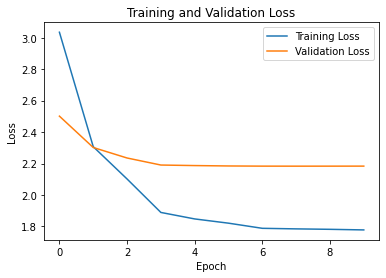

In [10]:
# 추가: 훈련 및 검증 손실 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()